In [2]:
import pandas as pd
import numpy as np
import skfuzzy as fuzz
from skfuzzy import control as ctrl
import matplotlib.pyplot as plt

# 1. Muat Dataset dan Ambil 100 Baris Pertama
# Dataset Anda bernama 'survey.csv'
df_full = pd.read_csv('survey.csv')
df_tugas = df_full.head(100).copy() # Ambil 100 baris pertama

print(f"Total baris yang digunakan: {len(df_tugas)}")

Total baris yang digunakan: 100


In [3]:
# Kolom yang akan digunakan
INPUT_1 = 'work_interfere'
INPUT_2 = 'care_options'
OUTPUT_TARGET = 'Risk_Level_Score' # Akan kita buat nanti

# 1. Menghapus Nilai Kosong (NA) pada kolom yang dipilih
df_tugas.dropna(subset=[INPUT_1, INPUT_2], inplace=True)

# 2. Pemetaan Nilai Teks ke Numerik (Fuzzifikasi Awal)
# Mapping untuk INPUT 1: Gangguan Kerja
mapping_work = {'Never': 0, 'Rarely': 1, 'Sometimes': 2, 'Often': 3}
df_tugas['Work_Interfere_Num'] = df_tugas[INPUT_1].map(mapping_work)

# Mapping untuk INPUT 2: Opsi Perawatan
mapping_care = {'No': 0, 'Not sure': 1, 'Yes': 2}
df_tugas['Care_Options_Num'] = df_tugas[INPUT_2].map(mapping_care)

# Periksa hasil konversi
print("\n5 baris pertama data setelah konversi:")
print(df_tugas[['Work_Interfere_Num', 'Care_Options_Num']].head())


5 baris pertama data setelah konversi:
   Work_Interfere_Num  Care_Options_Num
0                   3                 1
1                   1                 0
2                   1                 0
3                   3                 2
4                   0                 0


In [4]:
# --- 3.1. Definisi Universe (Rentang Nilai) ---
# Input 1: Work Interference (0 sampai 3, rentang sekitar 0-3.5 untuk plot)
x_work = np.arange(0, 4, 0.1) 
# Input 2: Care Options (0 sampai 2, rentang sekitar 0-2.5 untuk plot)
x_care = np.arange(0, 3, 0.1) 
# Output: Risk Score (Kita tentukan rentang 0 sampai 10)
x_risk = np.arange(0, 11, 1)

# --- 3.2. Membuat Fuzzy Control System ---
work_interfere = ctrl.Antecedent(x_work, 'work_interfere')
care_options = ctrl.Antecedent(x_care, 'care_options')
risk_level = ctrl.Consequent(x_risk, 'risk_level')

# --- 3.3. Membuat Fungsi Keanggotaan (trapmf) ---

# Input 1: Work Interference (Picu Stres)
work_interfere['low'] = fuzz.trapmf(x_work, [0, 0, 1, 2])
work_interfere['medium'] = fuzz.trapmf(x_work, [1, 2, 2.5, 3])
work_interfere['high'] = fuzz.trapmf(x_work, [2, 3, 3, 3])

# Input 2: Care Options (Dukungan)
care_options['low'] = fuzz.trapmf(x_care, [0, 0, 0.5, 1])
care_options['medium'] = fuzz.trapmf(x_care, [0.5, 1, 1.5, 2])
care_options['high'] = fuzz.trapmf(x_care, [1.5, 2, 2, 2])

# Output: Risk Score
risk_level['low'] = fuzz.trapmf(x_risk, [0, 0, 3, 5])       # Aman
risk_level['medium'] = fuzz.trapmf(x_risk, [3, 5, 7, 9])    # Waspada
risk_level['high'] = fuzz.trapmf(x_risk, [7, 9, 10, 10])    # Berisiko Tinggi

In [5]:
# --- 4.1. Pembuatan Fuzzy Rules (Total 9 Aturan Penuh) ---

# PICU RENDAH (work_interfere['low'])
rule1 = ctrl.Rule(work_interfere['low'] & care_options['low'], risk_level['medium'])     # Low Picu & Low Dukungan -> Medium
rule2 = ctrl.Rule(work_interfere['low'] & care_options['medium'], risk_level['low'])  # Low Picu & Medium Dukungan -> Low
rule3 = ctrl.Rule(work_interfere['low'] & care_options['high'], risk_level['low'])   # Low Picu & High Dukungan -> Low

# PICU SEDANG (work_interfere['medium'])
rule4 = ctrl.Rule(work_interfere['medium'] & care_options['low'], risk_level['high']) # Medium Picu & Low Dukungan -> High
rule5 = ctrl.Rule(work_interfere['medium'] & care_options['medium'], risk_level['medium']) # Medium Picu & Medium Dukungan -> Medium
rule6 = ctrl.Rule(work_interfere['medium'] & care_options['high'], risk_level['medium']) # Medium Picu & High Dukungan -> Medium

# PICU TINGGI (work_interfere['high'])
rule7 = ctrl.Rule(work_interfere['high'] & care_options['low'], risk_level['high'])  # High Picu & Low Dukungan -> High
rule8 = ctrl.Rule(work_interfere['high'] & care_options['medium'], risk_level['high']) # High Picu & Medium Dukungan -> High
rule9 = ctrl.Rule(work_interfere['high'] & care_options['high'], risk_level['medium']) # High Picu & High Dukungan -> Medium

# --- 4.2. Membuat Control System dan Simulasi ---
risk_ctrl = ctrl.ControlSystem([rule1, rule2, rule3, rule4, rule5, rule6, rule7, rule8, rule9])
risk_sim = ctrl.ControlSystemSimulation(risk_ctrl)

In [6]:
# --- 4.3. Menghitung Fuzzy Score untuk Semua Baris Data (Perbaikan) ---

df_tugas[OUTPUT_TARGET] = np.nan # Kolom baru untuk hasil output fuzzy

for index, row in df_tugas.iterrows():
    # Set input dari data numerik
    input1_val = row['Work_Interfere_Num']
    input2_val = row['Care_Options_Num']
    
    # 1. Menghindari baris dengan nilai kosong (NA/None)
    if pd.isna(input1_val) or pd.isna(input2_val):
        continue

    try:
        # 2. Proses Inferensi dan Defuzzifikasi
        risk_sim.input['work_interfere'] = input1_val
        risk_sim.input['care_options'] = input2_val
        
        # Lakukan komputasi
        risk_sim.compute()
        
        # 3. Ambil hasil skor risiko HANYA JIKA komputasi berhasil
        df_tugas.loc[index, OUTPUT_TARGET] = risk_sim.output['risk_level']
        
    except ValueError as e:
        # Menangkap error jika proses compute gagal total
        print(f"Warning: Compute gagal pada Index {index}. Error: {e}")
        df_tugas.loc[index, OUTPUT_TARGET] = np.nan
        
    except KeyError as e:
        # Menangkap KeyError jika output tidak terdefinisi (biasanya karena kegagalan compute)
        print(f"Warning: KeyError pada Index {index}. Output 'risk_level' tidak ditemukan. Error: {e}")
        df_tugas.loc[index, OUTPUT_TARGET] = np.nan
        
print("\nPerhitungan Fuzzy selesai. Hasil skor risiko:")
print(df_tugas[[INPUT_1, INPUT_2, 'Work_Interfere_Num', 'Care_Options_Num', OUTPUT_TARGET]].head())


Perhitungan Fuzzy selesai. Hasil skor risiko:
  work_interfere care_options  Work_Interfere_Num  Care_Options_Num  \
0          Often     Not sure                   3                 1   
1         Rarely           No                   1                 0   
2         Rarely           No                   1                 0   
3          Often          Yes                   3                 2   
4          Never           No                   0                 0   

   Risk_Level_Score  
0          8.916667  
1          6.000000  
2          6.000000  
3          6.000000  
4          6.000000  



Kolom Insight baru:
  Kategori_Stres Perlu_Intervensi
0         Tinggi               YA
1         Sedang            TIDAK
2         Sedang            TIDAK
3         Sedang               YA
4         Sedang            TIDAK


C:\Users\danie\anaconda3\Lib\site-packages\skfuzzy\control\fuzzyvariable.py:125: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


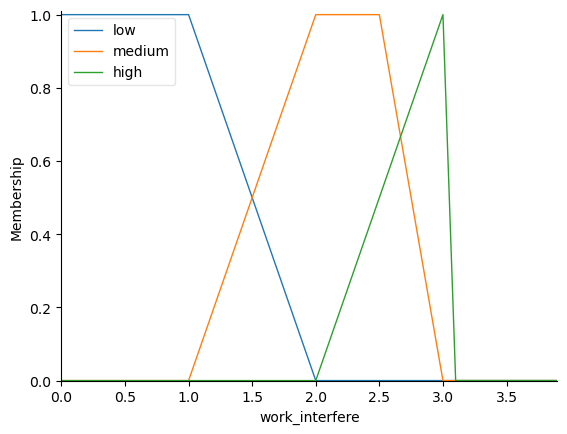

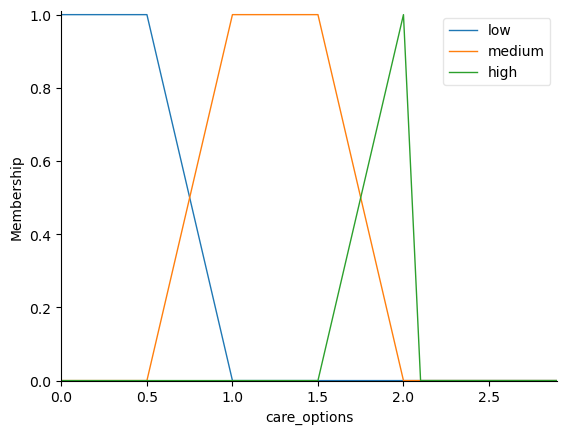

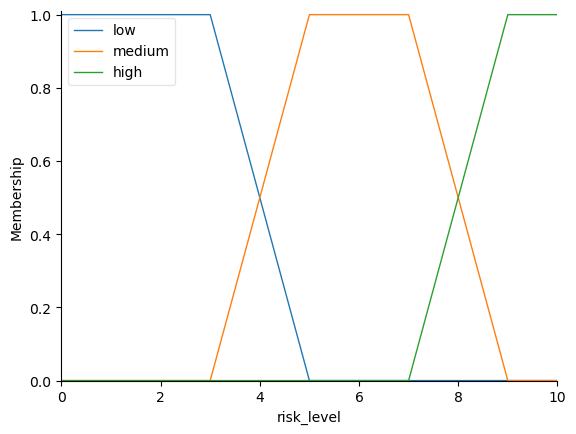

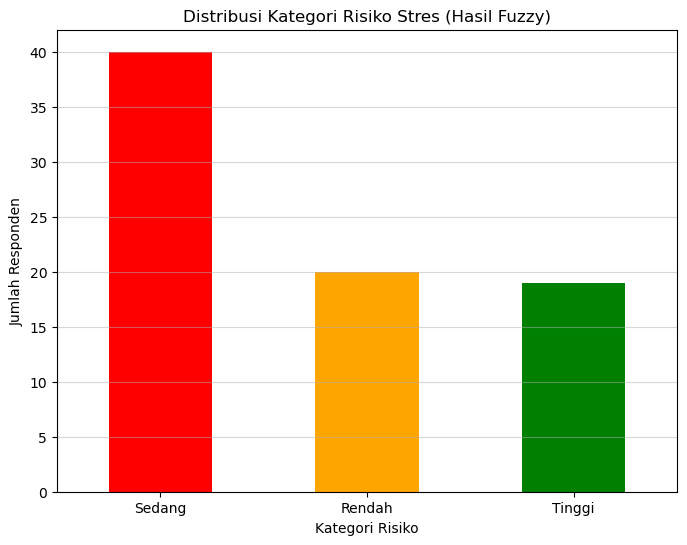

In [7]:
# --- 5.1. Menambah Kolom Baru: Kategori_Stres (Insight 1) ---

# Fungsi untuk mengkategorikan skor risiko (0-10)
def categorize_risk(score):
    if score >= 7:
        return 'Tinggi'
    elif score >= 4:
        return 'Sedang'
    else:
        return 'Rendah'

df_tugas['Kategori_Stres'] = df_tugas[OUTPUT_TARGET].apply(categorize_risk)

# --- 5.2. Menambah Kolom Baru: Perlu_Intervensi (Insight 2) ---

# Insight logis: Jika Kategori Tinggi ATAU punya riwayat keluarga (family_history='Yes')
# Kita asumsikan kolom 'family_history' ada di df_tugas
df_tugas['Perlu_Intervensi'] = np.where(
    (df_tugas['Kategori_Stres'] == 'Tinggi') | (df_tugas['family_history'] == 'Yes'),
    'YA',
    'TIDAK'
)
print("\nKolom Insight baru:")
print(df_tugas[['Kategori_Stres', 'Perlu_Intervensi']].head())


# --- 5.3. Visualisasi Hasil Fuzzy dan Data ---

# A. Plot Fungsi Keanggotaan (Membership Functions)
work_interfere.view()
plt.savefig('mf_work_interfere.png') 
care_options.view()
plt.savefig('mf_care_options.png') 
risk_level.view()
plt.savefig('mf_risk_level.png') 
plt.show() # Tiga gambar plot fungsi keanggotaan akan muncul

# B. Histogram Kategori Hasil
plt.figure(figsize=(8, 6))
df_tugas['Kategori_Stres'].value_counts().plot(kind='bar', color=['red', 'orange', 'green'])
plt.title('Distribusi Kategori Risiko Stres (Hasil Fuzzy)')
plt.xlabel('Kategori Risiko')
plt.ylabel('Jumlah Responden')
plt.xticks(rotation=0)
plt.grid(axis='y', alpha=0.5)
plt.savefig('histogram_kategori_stres.png')
plt.show()

In [8]:
# Tambahkan cell kode ini dan jalankan
kolom_output = ['Timestamp', 'Age', 'Gender', 'family_history', 
                'work_interfere', 'care_options', 'Work_Interfere_Num', 
                'Care_Options_Num', 'Risk_Level_Score', 'Kategori_Stres', 
                'Perlu_Intervensi']

# Pilih kolom yang relevan dan simpan
df_final = df_tugas[df_tugas.columns.intersection(kolom_output)].copy()

df_final.to_csv('fuzzy_mental_health_results.csv', index=False)
print("File hasil akhir 'fuzzy_mental_health_results.csv' sudah disimpan.")

File hasil akhir 'fuzzy_mental_health_results.csv' sudah disimpan.
